# Laminet Prototype: Real Training with Coherence Loss (Curated 10k Dataset + Field Visualization)

In [1]:
!pip install torch matplotlib numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
import json
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.animation as animation


In [3]:
with open('/content/laminet_10k_curated.json', 'r') as f:
    data = json.load(f)

themes = sorted(list(set([item['label'] for item in data])))
label_to_idx = {label: idx for idx, label in enumerate(themes)}

from sentence_transformers import SentenceTransformer
encoder = SentenceTransformer('all-MiniLM-L6-v2')

sentences = [item['text'] for item in data]
embeddings = encoder.encode(sentences, convert_to_tensor=True).cpu()



In [8]:
class FieldPoint(nn.Module):
    def __init__(self, embed_dim, device='cpu'):
        super().__init__()
        self.position = nn.Parameter(torch.randn(embed_dim, device=device))
        self.velocity = nn.Parameter(torch.zeros(embed_dim, device=device))
        self.mass = nn.Parameter(torch.ones(1, device=device))
        self.charge = nn.Parameter(torch.randn(1, device=device))
        self.decay_rate = nn.Parameter(torch.abs(torch.randn(1, device=device)))

class LaminaField(nn.Module):
    def __init__(self, embeddings):
        super().__init__()
        self.points = nn.ModuleList([FieldPoint(embeddings.shape[1], device=embeddings.device) for _ in range(len(embeddings))])

        self.embed_points(embeddings)

    def embed_points(self, embeddings):
        for point, embed in zip(self.points, embeddings):
            point.position.data = embed

    def evolve(self, dt=0.01, steps=50, record_positions=False):
        trajectory = []
        for _ in range(steps):
            if record_positions:
                current_positions = torch.stack([p.position for p in self.points]).detach().cpu().numpy()
                trajectory.append(current_positions)
            for idx, point in enumerate(self.points):
                net_force = self.compute_net_force(idx)
                point.velocity.data = point.velocity.data + net_force * dt
                point.position.data = point.position.data + point.velocity.data * dt
                point.velocity.data *= (1.0 - point.decay_rate.abs() * dt)
        if record_positions:
            return trajectory
        else:
            return None

    def compute_net_force(self, idx):
        net_force = 0
        point = self.points[idx]
        for j, other in enumerate(self.points):
            if j == idx:
                continue
            direction = other.position - point.position
            distance = direction.norm(p=2) + 1e-6
            force_mag = (point.charge * other.charge) / (distance**2)
            net_force += (force_mag * direction / distance)
        return net_force


In [9]:
class LaminetMicro(nn.Module):
    def __init__(self, embed_dim=64, output_dim=6):
        super().__init__()
        self.embedding = nn.Linear(384, embed_dim)

        self.decoder = nn.Linear(embed_dim, output_dim)

    def forward(self, x, evolution_steps=50, record_positions=False):
        x_embed = self.embedding(x)
        field = LaminaField(x_embed)
        trajectory = field.evolve(steps=evolution_steps, record_positions=record_positions)
        final_pos = torch.stack([p.position for p in field.points], dim=0)
        output = self.decoder(final_pos.mean(dim=0))
        return output, final_pos, trajectory


In [10]:
def coherence_loss(positions, labels):
    loss = 0
    count = 0
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            same = (labels[i] == labels[j])
            dist = (positions[i] - positions[j]).norm()
            if same:
                loss += dist  # Want same-label points to be closer
            else:
                loss += (1.0 / (dist + 1e-6))  # Want different-label points to repel
            count += 1
    return loss / count


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LaminetMicro(output_dim=len(themes)).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def generate_batch(batch_size=32):
    indices = random.sample(range(len(embeddings)), batch_size)
    batch_inputs = embeddings[indices]
    batch_labels = torch.tensor([label_to_idx[data[i]['label']] for i in indices])
    return batch_inputs.to(device), batch_labels.to(device)


epochs = 5
batch_size = 32

loss_history = []

for epoch in range(epochs):
    running_loss = 0.0
    for _ in tqdm(range(len(data) // batch_size)):
        inputs, labels = generate_batch(batch_size)
        optimizer.zero_grad()
        output, positions, _ = model(inputs, evolution_steps=30)
        loss = coherence_loss(positions, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / (len(data) // batch_size)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


100%|██████████| 3/3 [00:14<00:00,  4.78s/it]


Epoch 1, Loss: 1.0808


100%|██████████| 3/3 [00:14<00:00,  4.84s/it]


Epoch 2, Loss: 1.2123


100%|██████████| 3/3 [00:14<00:00,  4.91s/it]


Epoch 3, Loss: 1.1057


100%|██████████| 3/3 [00:14<00:00,  4.73s/it]


Epoch 4, Loss: 1.1377


100%|██████████| 3/3 [00:14<00:00,  4.74s/it]

Epoch 5, Loss: 1.1972


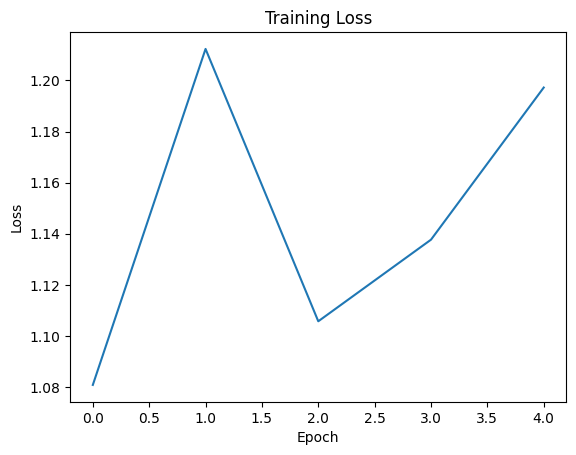

In [12]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


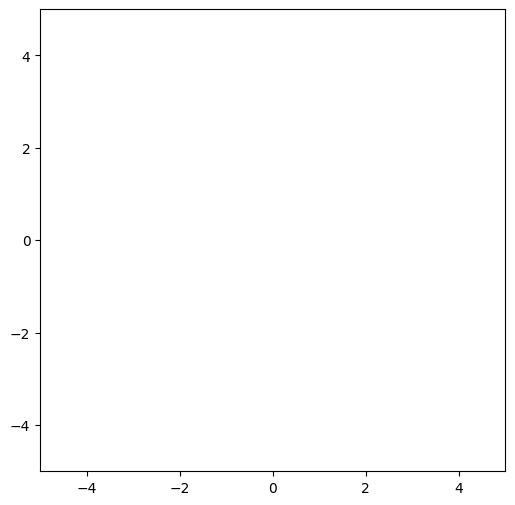

In [13]:
def animate_field(trajectory, labels, label_to_color):
    fig, ax = plt.subplots(figsize=(6,6))
    scat = ax.scatter([], [], c=[])

    def init():
        ax.set_xlim(-5,5)
        ax.set_ylim(-5,5)
        return scat,

    def update(frame):
        positions = trajectory[frame]
        if positions.shape[1] > 2:
            positions = positions[:, :2]
        colors = [label_to_color[lbl] for lbl in labels]
        scat.set_offsets(positions)
        scat.set_color(colors)
        return scat,

    ani = animation.FuncAnimation(fig, update, frames=len(trajectory), init_func=init, blit=True)
    plt.show()
    return ani

# Visualize after training
batch = random.sample(data, 32)
inputs = torch.randn(32, 128).to(device)
batch_labels = [item['label'] for item in batch]
theme_colors = {
    'Discovery': 'green',
    'Love Story': 'pink',
    'Mystery': 'purple',
    'Quest': 'blue',
    'Revenge': 'red',
    'Science': 'orange'
}

torch.save(model.state_dict(), 'laminet_micro_trained.pt')


model.eval()
with torch.no_grad():
    output, _, trajectory = model(inputs, evolution_steps=50, record_positions=True)
animate_field(trajectory, batch_labels, theme_colors)
